# Investigating device properties with GEM experiment


### 1. Overview
GEM (Generation of Entanglement by Measurement) is a measurement-based technique to prepare device-wide entangling states with constand-depth circuits, which is introduced by [the paper from Edward H. Chen et. al](https://arxiv.org/abs/2309.02863). Our library provides its [Qiskit Experiments](https://github.com/Qiskit-Extensions/qiskit-experiments) implementation for conventional IBM Quantum processors with the heavy hexagonal lattice topology, with 2D preparation protocol which is know to be highly noise-resistant. In the GEM protocol, an atomic unit of the experiment is called plaquette. For instance, a single heavy hexagonal lattice forms a single plaquette with a collection of 12 qubits. In other words, an 127 qubit Eagle device can be represented by only 18 plaquettes.

In [1]:
from gem_suite import PlaquetteLattice
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

In [2]:
plaquettes = PlaquetteLattice.from_backend(FakeSherbrooke())

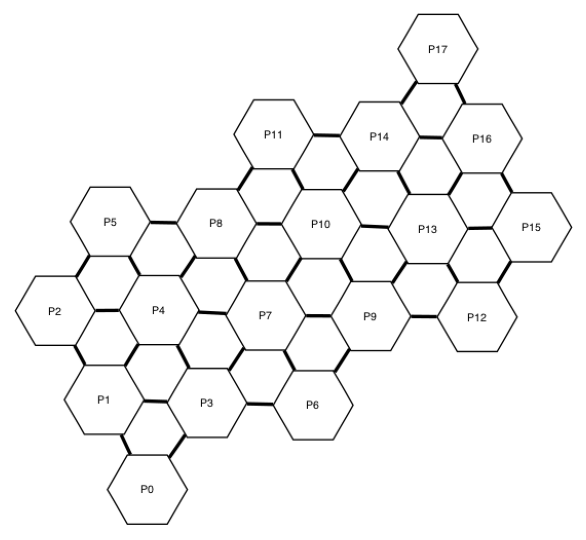

In [3]:
plaquettes.draw_plaquettes()

We can get component qubits in each plaquette by calling the `.plaquettes` method.

In [4]:
next(plaquettes.plaquettes())

PyPlaquette(index=0, qubits=[0, 1, 2, 3, 4, 14, 15, 18, 19, 20, 21, 22], neighbors=[3, 1])

Conventional qubit coupling graph is also available with some convenient annotations to prepare experiment circuits. In the GEM protocol, qubits are classified into site and bond qubits. In this graph view, the filled (open) circuits are site (bond) qubits. To turn an initial product state of site qubits in +1 X eigenstates into GHZ-type state, we measure the ZZ parities on all nearest neighbor site qubits using the bond qubits in between. We sweep the control rotation angle to "A" sublattice (site qubits with annotation "A") to implement a coupling to bond qubits beyond a simple Clifford CNOT gate. By varing this angle away from the Clifford limit, we can perform tunable weak measurement.

In the heavy hexagonal lattice, we always need three layers of entangling operations due to the degree-3 connectivity. Note that edges in the graph are also grouped by different colors. We schedule this graph edges so that no adjacent edges appear in the same layer to aviod collisions. In this configuration, we can generate 12 different scheduling patterns which may yield different noise levels due to different contribution of gate crosstalks.

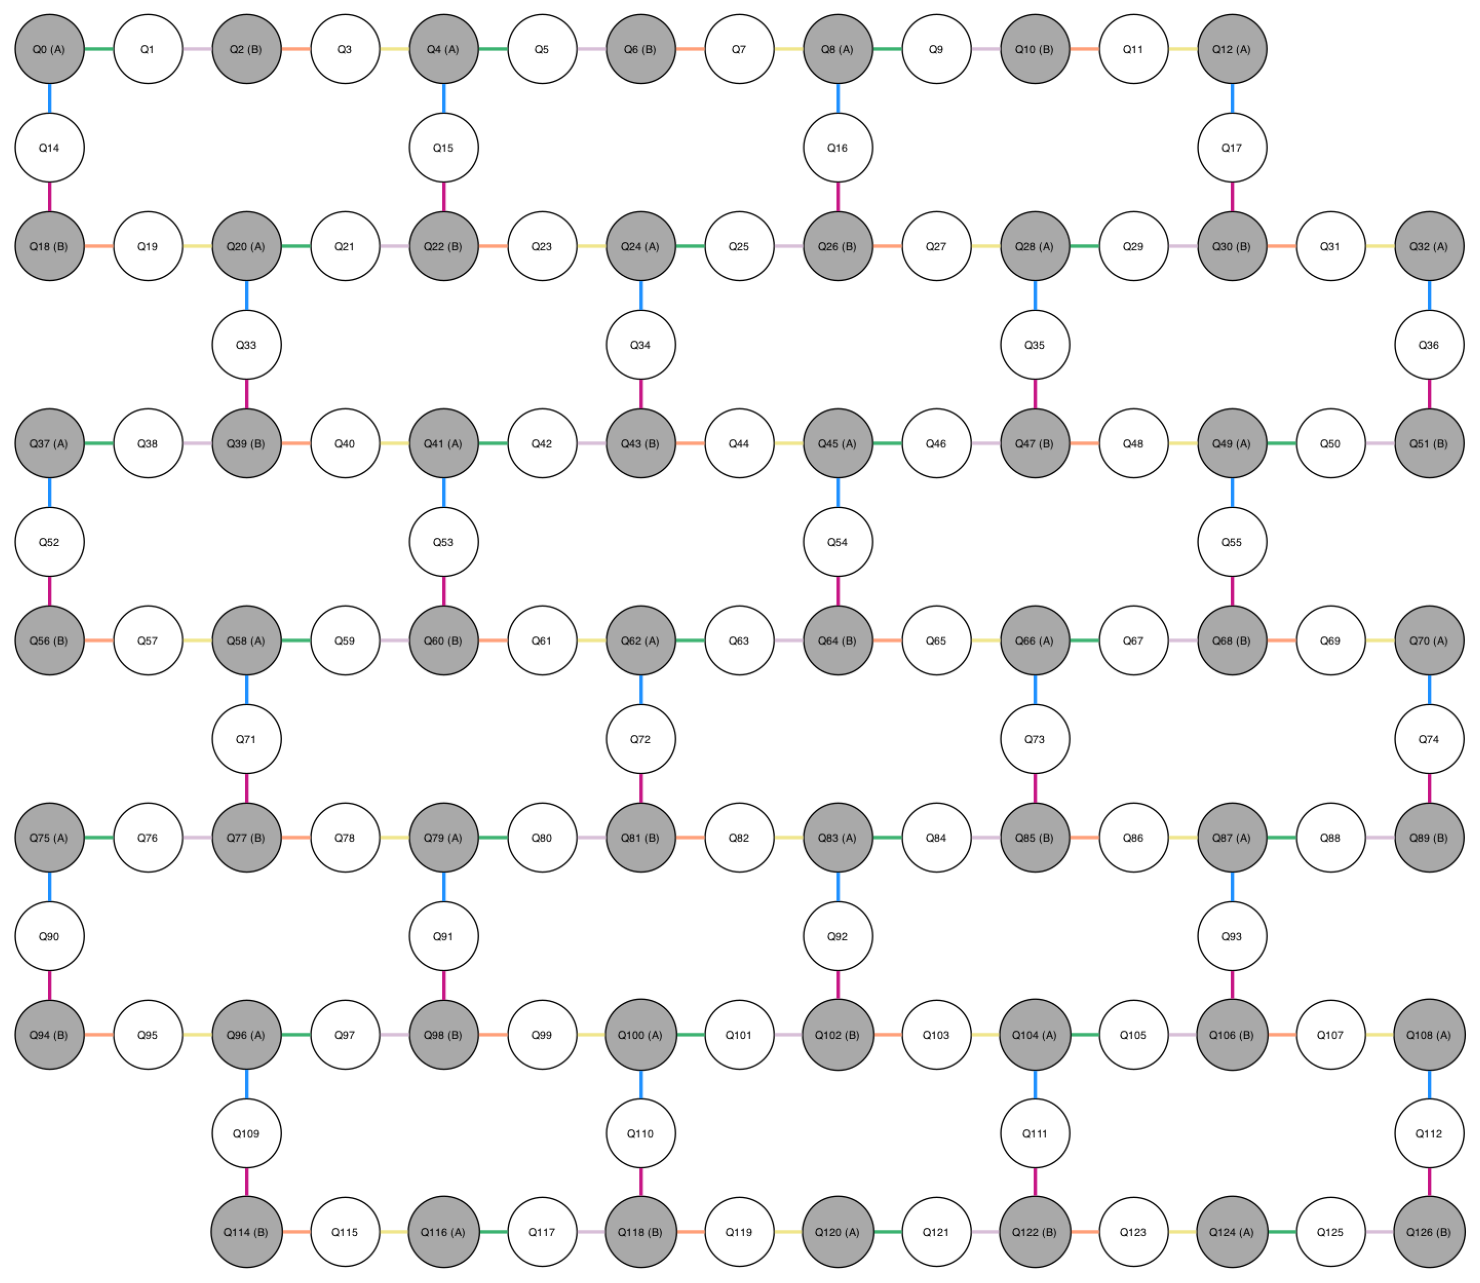

In [41]:
plaquettes.draw_qubits()

The `PlaquetteLattice` offers a method to generate the gate schedules by consuming above annotated qubit graph. You can prepare GEM circuits with this information.

In [6]:
for i, group in enumerate(plaquettes.build_gate_schedule(10)):
    print(f"group #{i}")
    for j, edge in enumerate(group):
        if j > 5:
            print("...")
            break
        print(edge)

group #0
PyGate(index0=3, index1=4, group="A")
PyGate(index0=7, index1=8, group="A")
PyGate(index0=11, index1=12, group="A")
PyGate(index0=19, index1=20, group="A")
PyGate(index0=23, index1=24, group="A")
PyGate(index0=27, index1=28, group="A")
...
group #1
PyGate(index0=0, index1=1, group="A")
PyGate(index0=4, index1=5, group="A")
PyGate(index0=8, index1=9, group="A")
PyGate(index0=20, index1=21, group="A")
PyGate(index0=24, index1=25, group="A")
PyGate(index0=28, index1=29, group="A")
...
group #2
PyGate(index0=0, index1=14, group="A")
PyGate(index0=4, index1=15, group="A")
PyGate(index0=8, index1=16, group="A")
PyGate(index0=12, index1=17, group="A")
PyGate(index0=20, index1=33, group="A")
PyGate(index0=24, index1=34, group="A")
...


You can also build a sublattice from your plaquette lattice, if you have a particular subset of interest to run experiment.

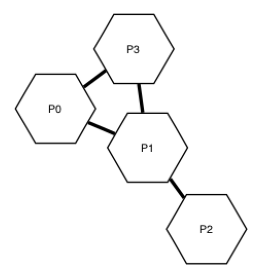

In [7]:
sub_plaquettes = plaquettes.filter([0, 1, 2, 3])
sub_plaquettes.draw_plaquettes()

### 2. Running through Qiskit Experiments
Now let's move on to integaration into Qiskit Experiments. Although in principle you can build and run the GEM experiment manually, it's convenient to run it through Qiskit Experiments class.

In [8]:
from gem_suite.experiments import GemExperiment
from qiskit_ibm_runtime.fake_provider import FakeGeneva

In [9]:
gem_exp = GemExperiment([0, 1], backend=FakeGeneva())

The experiment class can be instantiated either with numerical indices of plaquettes or a `PlaquetteLattice` instance. In this example, we use FakeGeneva backend with 27 qubits so that the experiment can run on the Qiskit Aer simulator. You must install `pip install qiskit-aer` to continue.

In [10]:
gem_exp.experiment_options

Options(max_circuits=None, schedule_idx=None, sweep_type='A', min_angle=0, max_angle=1.5707963267948966, num_angles=21, angles=None)

In [11]:
gem_exp.set_experiment_options(schedule_idx=10)

We only simulate a single scheduling pattern since this simulation is expensive. In default setting, the GEM experiment runs 21 experiment circuits with different control rotation angles from [0, pi/2], where pi/2 is at the Clifford limit. Without specifying the `scheduling_idx`, the experiment tries all 12 scheduling patterns and computes the result as an average of these patterns. In total, 252 circuits will run in a single execution. Here we run only scheduling index 10.

With a real backend, we can simply run following code to get the results.

In [ ]:
# exp_data = gem_exp.run().block_for_results()

However, in case of the density matrix simulator, noisy ISA circuits with 27 qubits are hardly executed on a standard laptop computer. Instead, we use a bit of underhanded tricks to bypass transpile and consideration of ancilla qubits in the full layout. We will see the complete workflow with a real utility scale computer later.

Without transpiling, the GEM circuits have only 21 qubits. This circuit can be simulated run on your laptop. Here we directly run virtual (non-transpiled) circuit on the Aer simulator with a noise model. In contrast to RB-variant protocols, such as the [layer fidelity experiment](https://arxiv.org/abs/2311.05933), the GEM protocol is sensitive to the measurement error by design, and we recover the noiseless state with the minimum weight perfect matching (MWPM) decoder. At a critical control angle, this recovery starts to fail where we consider the Nishimori transition occurs.

In this simulation, we only consider the impact of measurement errors.

In [12]:
from qiskit_experiments.framework import ExperimentData
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError

import numpy as np

In [13]:
rng = np.random.default_rng(1234)

noise_model = NoiseModel()
for vi, _ in enumerate(gem_exp.physical_qubits):
    err = rng.uniform(0.0, 0.1)
    noise_model.add_readout_error(ReadoutError([[1.0 - err, err], [err, 1.0 - err]]), [vi])
sim_backend = AerSimulator(noise_model=noise_model, seed_simulator=5678)

In [14]:
job = sim_backend.run(gem_exp.circuits(), shots=10000)

In [15]:
exp_data = ExperimentData(experiment=gem_exp)
exp_data.add_jobs(job)
exp_data.block_for_results()

Adding a job from a backend (AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure']>)) that is different than the current backend (<qiskit_ibm_runtime.fake_provider.backends.geneva.fake_geneva.FakeGeneva object at 0x12fb61650>). The new backend will be used, but service is not changed if one already exists.


ExperimentData(GemExperiment, 4dbdbb18-6e63-44e1-af06-bed6b9c6d9a6, job_ids=['a1e6ba73-6f7b-4f92-87f5-c1d00970aace'], metadata=<5 items>)

In [16]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 363 ms, sys: 26.6 ms, total: 390 ms
Wall time: 389 ms


After the experiment completes, we can get four quantities in the analysis results dataframe. Each parameter characterizes the capability of entanglement preparation of this quantum processor from different aspect.

- max_tpc: Maximum two-point (classical) correlation between two site qubits. The higher the value, the better the entanglement generation capability.
- critical_angle: A control rotation angle where the Nishimori transition occurs. 0.5 is the Clifford limit and maximum value of the quantity. The smaller the value, the better the noise tolerance.
- p_bond_mean: A parameter characterizing the average measurement error in bond qubits and noise during the entangling process.
- p_site_mean: A parameter characterizing the average measurement error in site qubits.

*** CAN WE NORMALIZE TPC BY QUBIT SIZE?

In [17]:
analyzed_data.analysis_results(dataframe=True)

,name,experiment,components,value,quality,backend,run_time,chisq,aic
38e5ab7a,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",6.15+/-0.04,None,aer_simulator,None,None,None
193d1af4,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.4,None,aer_simulator,None,None,None
7ec02fd7,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0540+/-0.0031,Good,aer_simulator,None,0.681119,-6.166142
e8fb5920,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.048+/-0.006,Good,aer_simulator,None,0.681119,-6.166142


In addition to above numbers, you will find four figures associated with the result.

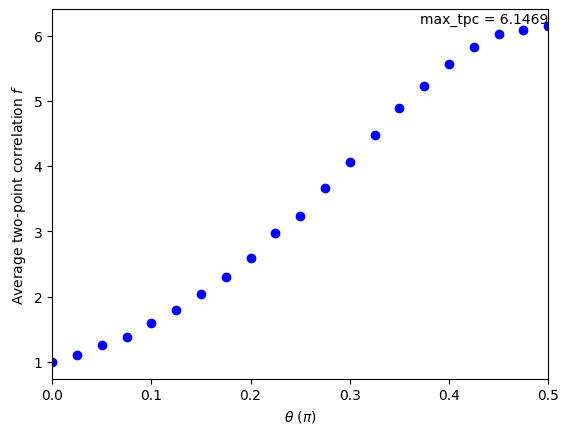

In [18]:
analyzed_data.figure(0)

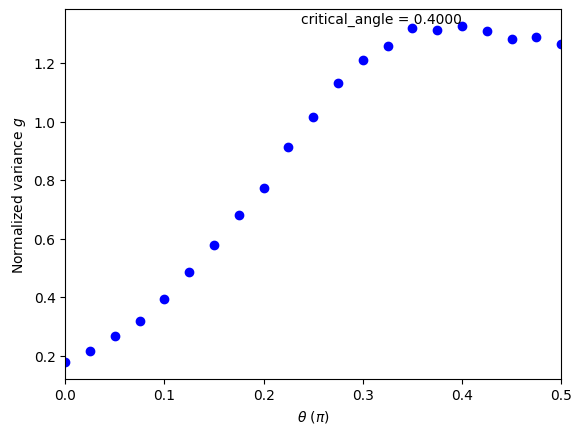

In [19]:
analyzed_data.figure(1)

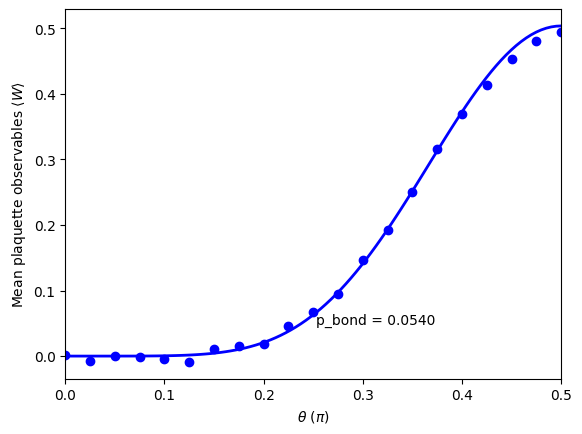

In [20]:
analyzed_data.figure(2)

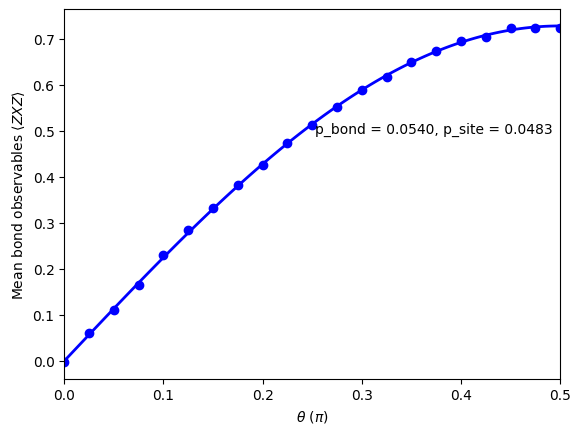

In [21]:
analyzed_data.figure(3)

### 3. Customizing measurement options
You can also customize analysis options.

In [22]:
gem_exp.analysis.options

Options(figure_names=None, analyze_individual_bond=False, analyze_clifford_limit=False, decoder='pymatching')

First, our library implements two MWPM decoders, namely [pymatching](https://github.com/oscarhiggott/PyMatching) and [fusion-blossom](https://github.com/yuewuo/fusion-blossom). The quality of the result doesn't significantly depend on the choice of decoder and they are tested against the same mock configuration to confirm the results are comparable. Unfortunately the latter is slower (although its implemented in Rust and in principle there is no FFI overhead with our library, which is also written in Rust). Thus, our setting defaults to the pymatching decoder.

Note that in the default configuration we only see the wholistic metrics of the entire processor. We can also produce local properties in different levels. With small addition of computing resources, you can obtain a quality metric for each plaquette.

In [23]:
gem_exp.analysis.set_options(analyze_clifford_limit=True, analyze_individual_bond=False, decoder="pymatching")

In [24]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 383 ms, sys: 60.1 ms, total: 443 ms
Wall time: 709 ms


In [25]:
res = analyzed_data.analysis_results(dataframe=True); res

,name,experiment,components,value,quality,backend,run_time,chisq,aic,plaquette
83d54dbc,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",6.15+/-0.04,None,aer_simulator,None,None,None,None
b5a81cb8,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.4,None,aer_simulator,None,None,None,None
e0b4a01f,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0540+/-0.0031,Good,aer_simulator,None,0.681119,-6.166142,None
84657b3e,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.048+/-0.006,Good,aer_simulator,None,0.681119,-6.166142,None
678317ff,plaquette_quality,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.6392604216332078+/-0,None,aer_simulator,None,None,None,0
7da07ecd,plaquette_quality,GemExperiment,"[Q12, Q13, Q14, Q15, Q16, Q18, Q19, Q21, Q22, ...",0.5566068091570565+/-0,None,aer_simulator,None,None,None,1


The quality metric is computed by the square root of the product of $\left(\langle W \rangle \overline{\langle ZXZ \rangle}\right)^{1/2}$ at the Clifford limit, where the $\langle W \rangle = \langle ZZZZZZ \rangle$ is the plaquette observable of six site qubits in the plaquette, and the $\overline{\langle ZXZ \rangle}$ is the average of bond correlations in the plaquette. You must include pi/2 in your experiment parameter to obtain these numbers. Without noise, this metric becomes 1.0 and it is somewhat related to the regional quality of your quantum processor. This may help you to extract the best part of your processor to run circuits.

In [26]:
best_qubits = [q.index for q in res[res.name == "plaquette_quality"].sort_values("value", ascending=False).iloc[0].components]
best_qubits

[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14]

This option will produce an extra figure to visualize the distribution of metric across different plaquettes regions. The brightness of the filled plaquettes is proportional to the value of the metric.

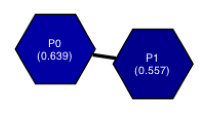

In [27]:
analyzed_data.figure(4)

In principle, we can compute p_bond and p_site parameters for each bond. This will produce more localized view of the device quality.

In [28]:
gem_exp.analysis.set_options(analyze_clifford_limit=False, analyze_individual_bond=True, decoder="pymatching")

In [29]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 769 ms, sys: 131 ms, total: 901 ms
Wall time: 526 ms


/Users/knzwnao/Develop/venv/gem/lib/python3.11/site-packages/gem_suite/sub_analysis/operators.py:377: RuntimeWarning: divide by zero encountered in log
  aic = n_data * np.log(chisq / n_data) + 2 * len(init)


In [30]:
res = analyzed_data.analysis_results(dataframe=True); res

,name,experiment,components,value,quality,backend,run_time,chisq,aic
e7ce6dcb,max_tpc,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",6.15+/-0.04,None,aer_simulator,None,None,None
067d4669,critical_angle,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.4,None,aer_simulator,None,None,None
4b54476a,p_bond_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.0540+/-0.0031,Good,aer_simulator,None,0.681119,-6.166142
eb34aea1,p_site_mean,GemExperiment,"[Q1, Q2, Q3, Q4, Q5, Q7, Q8, Q10, Q11, Q12, Q1...",0.048+/-0.006,Good,aer_simulator,None,0.681119,-6.166142
2f68d4b6,p_bond,GemExperiment,"[Q2, Q3, Q1]",0.49999999999999989+/-0.00000000000000022,Good,aer_simulator,None,0.87315,-0.950364
cc9a6ac5,p_site,GemExperiment,"[Q2, Q3, Q1]",0.5+/-0.6,Good,aer_simulator,None,0.87315,-0.950364
6a0323f8,p_bond,GemExperiment,"[Q4, Q7, Q1]",0.5+/-nan,Good,aer_simulator,None,0.0,-inf
bdd3b63a,p_site,GemExperiment,"[Q4, Q7, Q1]",0.46077917785536154+/-nan,Good,aer_simulator,None,0.0,-inf
10fff51b,p_bond,GemExperiment,"[Q5, Q8, Q3]",0.5+/-nan,Good,aer_simulator,None,0.0,-inf
f5bdffcb,p_site,GemExperiment,"[Q5, Q8, Q3]",0.4629614006961291+/-nan,Good,aer_simulator,None,0.0,-inf


### 4. Utility-scale experiemnt with real quantum processor

Lastly we run the GEM experiment on a real quantum processor from IBM Quantum. The workflow is much simpler because there is no resource limit in the classical computation to run the experiment. We just run it and wait for the result. In this example we test all 12 scheduling patterns to see the dependency on the gate crosstalk. The more divergent the traces (i.e. gray lines behind blue scatters), the greater the contribution of the gate crosstalk.

With the one of the Eagle processors ibm_osaka, we can run the GEM experiment with 18 plaquettes.

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [32]:
backend = QiskitRuntimeService().backend("ibm_osaka")

In [34]:
gem_exp = GemExperiment(range(18), backend=backend)
exp_data = gem_exp.run(analysis=None).block_for_results()

ExperimentData(GemExperiment, dee229dc-fb15-4f58-8a31-c9e3d5de5574, job_ids=['ctwqyd166x8g008q72kg'], metadata=<5 items>)

In [35]:
%%time
analyzed_data = gem_exp.analysis.run(exp_data).block_for_results()

CPU times: user 9.82 s, sys: 198 ms, total: 10 s
Wall time: 10.3 s


In [36]:
analyzed_data.analysis_results(dataframe=True)

,name,experiment,components,value,quality,backend,run_time,chisq,aic
fcaf6657,max_tpc,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",2.325+/-0.014,None,ibm_osaka,None,None,None
73418c51,critical_angle,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.475,None,ibm_osaka,None,None,None
050136c8,p_bond_mean,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.274+/-0.011,Good,ibm_osaka,None,0.959481,1.029628
2371cf98,p_site_mean,GemExperiment,"[Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, ...",0.136+/-0.015,Good,ibm_osaka,None,0.959481,1.029628


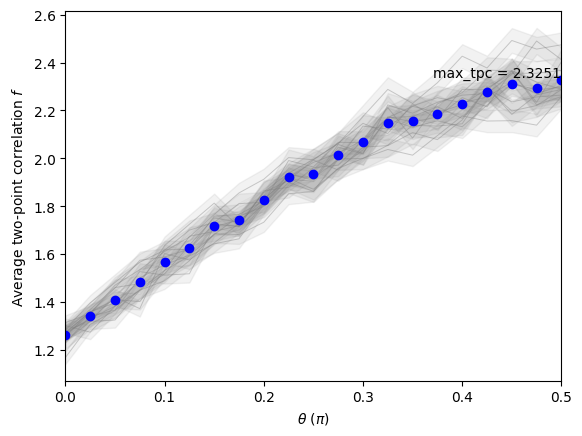

In [37]:
analyzed_data.figure(0)

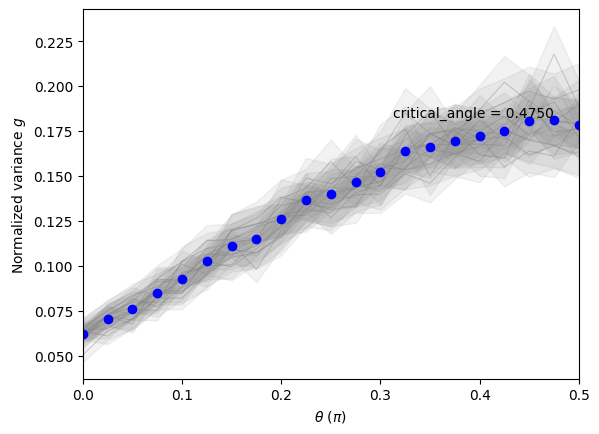

In [38]:
analyzed_data.figure(1)

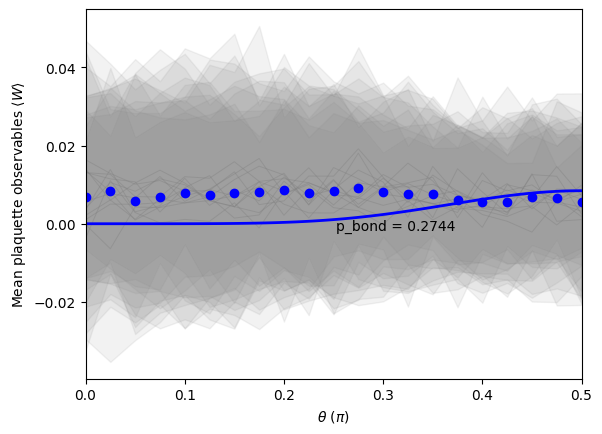

In [39]:
analyzed_data.figure(2)

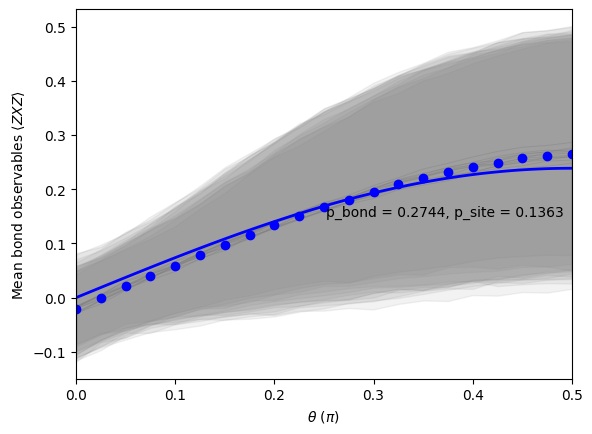

In [40]:
analyzed_data.figure(3)